In [7]:
import os
import sys

for _ in os.listdir('/home/gqbao/rl'):
    _ = '/home/gqbao/rl/' + _
    try:
        sys.path.remove(_)
    except ValueError:
        pass

sys.path.append('/home/gqbao/rl/dqn')

In [8]:
import gymnasium as gym
import numpy as np
import torch
import agent
import math
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

In [9]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


def plot_return(return_list: list, ave_epi=100, is_res=False, sav_dir=''):
    plt.figure(1)
    return_tensor_list = torch.tensor(return_list, dtype=torch.float32)

    if is_res:
        plt.title('RESULT')
    else:
        plt.clf()
        plt.title('TRAINING...')

    plt.xlabel('EPISODE')
    plt.ylabel('RETURN')
    plt.plot(return_list)

    if len(return_list) >= ave_epi:
        mean_return = return_tensor_list.unfold(0, ave_epi, 1).mean(1).view(-1)
        mean_return = torch.cat((mean_return, mean_return[-ave_epi + 1:]))
        plt.plot(mean_return)

    if is_res:
        plt.savefig(sav_dir + '/' + 'res.svg')

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not is_res:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [10]:
batch_size = 128
gamma = 0.99
# 采用递减的 epsilon
# 初始生成的探索策略，探索范围较大，之后的探索策略范围逐渐变小
epsilon_start = 0.9
epsilon_end = 0.05
epsilon_decay = 1000
sample_count = 0
# target 网络更新频率，eval 网络经过这么多次更新即认为已经是好的逼近，此时可以赋值
update_fre = 10
# soft update 方式
is_soft_update = True
update_ratio = 0.01
learning_rate = 1e-4
buffer_capacity = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

episodes_num = 600

In [11]:
device

'cpu'

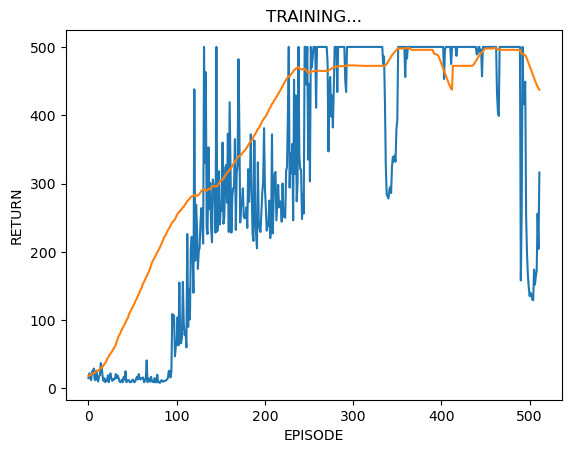

<Figure size 640x480 with 0 Axes>

In [ ]:
env = gym.make('CartPole-v1')
action_num = env.action_space.n
s, info = env.reset()
state_dim = len(s)
# print('state_dim', state_dim)
# print('action_num', action_num)

dqn = agent.DQN(state_dim, action_num, learning_rate, gamma, device, is_soft_update, update_fre=update_fre,
                update_ratio=update_ratio)
buffer = agent.ReplayBuffer(buffer_capacity)

return_list = []

# 用当前 eval_net 生成的行为策略去做决策，得到环境信息的采样，更新记忆区
# 用记忆区的数据更新 eval_net，其中 eval_net 更新一定次数后会结束策略评估，将值赋给 tar_net，生成新的目标策略，策略提升
# 重复策略评估以及提升
for episodes_i in range(episodes_num):

    # 该游戏，只要下一状态杆还不倒，奖励就是 1，倒了奖励就是 0
    episode_return = 0
    s, info = env.reset()

    while True:
        # 逐渐减少 epsilon
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1 * sample_count / epsilon_decay)
        sample_count += 1
        # 生成行为策略，决定当前动作
        a = dqn.choose_action(s, epsilon)
        # print('采样，动作', a)

        # 执行动作，得到反馈
        s_, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated

        # 得到环境信息，保存采样，更新记忆区
        buffer.push(s, a, r, s_, done)
        # 累加奖励
        episode_return += r
        if done:
            break
        else:
            s = s_

        # 更新网络参数，策略评估、策略提升
        dqn.update(buffer, batch_size)

    # 一幕结束，保存该慕获得的累加奖励
    # print('EPISODE: {}'.format(episodes_i), 'RETURN: {}'.format(episode_return))
    return_list.append(episode_return)
    plot_return(return_list, 100, False)

print('COMPLETE')

In [ ]:
# 绘制最终的 return 并且保存图片
now = datetime.now().strftime('%Y%m%d%H%M%S')
sav_dir = '/home/gqbao/rl/dqn/' + now
if not os.path.exists(sav_dir):
    os.makedirs(sav_dir)

plot_return(return_list, 100, True, sav_dir)
# 保存 return_list
np.save(sav_dir + '/' + 'return_list.npy', np.array(return_list))

In [ ]:
# 保存模型
dqn.save_net(sav_dir, True)

# 保存实验超参数
hyper_params = {'batch_size': batch_size, 'gamma': gamma, 'update_fre': update_fre,
                'is_soft_update': is_soft_update,
                'update_ratio': update_ratio, 'lr': learning_rate, 'buffer_capacity': buffer_capacity,
                'episodes_num': episodes_num, 'epsilon_start': epsilon_start, 'epsilon_end': epsilon_end,
                'epsilon_decay': epsilon_decay}
np.save(sav_dir + '/' + 'hyper_params.npy', hyper_params)

with open(sav_dir + '/' + 'log.txt', 'w+') as f:
    f.write('is_soft_update: {}\n'.format(is_soft_update))
    f.write('update_ratio: {}\n'.format(update_ratio))
    f.write('update_fre: {}\n'.format(update_fre))
    f.write('batch_size: {}\n'.format(batch_size))
    f.write('lr: {}\n'.format(learning_rate))
    f.write('gamma: {}\n'.format(gamma))
    f.write('episodes_num: {}\n'.format(episodes_num))
    f.write('epsilon_start: {}\n'.format(epsilon_start))
    f.write('epsilon_end: {}\n'.format(epsilon_end))
    f.write('epsilon_decay: {}\n'.format(epsilon_decay))
    f.write('buffer_capacity: {}\n'.format(buffer_capacity))